In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import glob
import os
import contextily as ctx
from scipy.spatial import cKDTree
from shapely.geometry import Point
import json
from tqdm.auto import tqdm
pd.set_option('min_rows', 30)
import sys
sys.path.append('..')
from importlib import reload
# import src.utils as utils
# reload(utils)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 16)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

## Setup

In [ ]:
%%time
parcels = gpd.read_file('input/lds-nz-primary-parcels-CLIPPED-4326.gpkg')

In [752]:
parcels_sample = parcels.sample(10000)

In [759]:
# keep a centroid and polygon version - change between them according to need
parcels_sample['geometry_polygon_2193'] = parcels_sample.geometry.to_crs(2193)
parcels_sample['geometry_centroid_2193'] = parcels_sample.geometry_polygon_2193.centroid
parcels_sample['geometry_centroid_4326'] = parcels_sample.geometry_centroid_2193.to_crs(4326)
parcels_sample['geometry_polygon_4326'] = parcels_sample.geometry_polygon_2193.to_crs(4326)

## 1. LINZ parcel information
##### a. **LINZ_parcel_ID** Parcel identifier - “certificate of title”.


In [734]:
parcels_sample['LINZ_parcel_ID'] = parcels_sample.id

##### b. **LINZ_parcel_centroid_lon**
##### c. **LINZ_parcel_centroid_lat**

In [745]:
parcels_sample['geometry'] = parcels_sample.geometry_centroid_4326
parcels_sample['LINZ_parcel_centroid_lon'] = parcels_sample.geometry.x
parcels_sample['LINZ_parcel_centroid_lat'] = parcels_sample.geometry.y

##### d. **LINZ_parcel_vertices_lon** vector of longitudes of the vertices of the matched LINZ parcels 
##### e. **LINZ_parcel_vertices_lat**

In [819]:
parcels_sample['geometry'] = parcels_sample.geometry_polygon_4326
# all are multipolygons
print(set([type(a) for a in parcels_sample.geometry]))

{<class 'shapely.geometry.multipolygon.MultiPolygon'>}


In [810]:
coordinates_all = []
for multipolygon in tqdm(parcels_sample.geometry):
    coordinates = []
    for polygon in multipolygon:
        coordinates.extend(polygon.exterior.coords)
    coordinates_all.append(coordinates)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [817]:
parcels_sample['LINZ_parcel_vertices_lon'] = [[p[0] for p in points] for points in coordinates_all]
parcels_sample['LINZ_parcel_vertices_lat'] = [[p[1] for p in points] for points in coordinates_all]

##### f. **LINZ_parcel_roadvertices_lon** subvector of longitudes of parcel that sits adjacent to a road 
##### g. **LINZ_parcel_roadvertices_lat**
##### h. **LINZ_parcel_sides_zones** AUP Zone Code of adjoining parcels (this includes residential, business, and rural zones; it should also include roads, water and open spaces)
##### i. i. **LINZ_TRNSPWR_ohead_indicator** Indicator (0 or 1) for LINZ parcel located under overhead transpower line. Leave blank otherwise. Note that ‘TRANSLINE’ denotes overhead transmission lines in the GIS dataset, while ‘CABLE’ denotes underground transmission lines and can be ignored. 
##### i. ii. **LINZ_TRNSPWR_ohead_name**
##### j. i. **LINZ_VWSHFT_ohead_indicator** Indicator (0 or 1) for LINZ parcel located under viewshafts. Leave blank otherwise. 
##### j. ii. **LINZ_VWSHFT_ohead_name** Name of the volcanic cone (e.g. Mt Albert). Leave blank if no viewshaft applies. 
##### j. iii. **LINZ_VWSHFT_ohead_ID** OBJECTID of the viewshaft. Leave blank if no viewshaft applies. 

## 2. AUP shapefile information. Calculations are based on centroid of matched parcels: 
##### a. **LINZmatch_AUP_name** AUP zone (string) consent is located in (from the AUP shapefiles) 
##### b. **LINZmatch_AUP_code** AUP Zone Code (numerical) consent is located in 

In [333]:
%%time
aup_zones = gpd.read_file('restricted/2016_Unitary_Plan_operational_15Nov/UP_OIP_15Nov2016_SHP/MASTER_UP_BaseZone.shp')
aup_zones = aup_zones.to_crs(2193)
aup_zones.sample(3)

CPU times: user 31.2 s, sys: 2.21 s, total: 33.4 s
Wall time: 33.3 s


WORKFLOWJO   last_edi00 CONTOUR   created_da DocumentUR  \
58724          NaN  20161111011    None  20160718211       None   
103279         NaN  20161111012    None  20160718211       None   
54081          NaN  20161111011    None  20160718211       None   

                                      GlobalID GROUPZONE GROUPZONE_    ID  \
58724   {0CCC66B0-9A15-477A-BE4F-FAE9C5FA9C15}         5    Coastal  None   
103279  {111B7716-6401-457F-A260-9BA18D7E0DB9}         5    Coastal  None   
54081   {CD16D435-B3A5-4C26-BFC7-E6AF32E60231}         7    General  None   

        NAME  OBJECTID PARCEL_BAS PARCEL_B00 PRECINCT PRECINCT_r PRECINCTGR  \
58724   None     58725       None       None     None       None       None   
103279  None    103280       None       None     None       None       None   
54081   None     54082       None       None     None       None       None   

       PRECINCT00 SCHEDULE    SHAPE_Area   SHAPE_Leng STATUS SUBPRECINC  \
58724        None     None     62.153950    58.346375   None       None   
103279       None     None    372.662968   106.669373   None       None   
54081        None     None  41502.960080  1179.183755   None       None   

       SUBPRECI00 SUBTYPE SUBTYPE_re  TYPE TYPE_resol VALIDATION  \
58724        None    None       None  None       None          3   
103279       None    None       None  None       None          3   
54081        None    None       None  None       None          3   

              VALIDATI00 VERSIONSTA VERSIONS00 ZONE  \
58724   Valid and Public          4  Operative   59   
103279  Valid and Public          4  Operative   30   
54081   Valid and Public          4  Operative   26   

                                   ZONE_resol  ZONEHEIGHT  \
58724       Coastal - Coastal Transition Zone         NaN   
103279  Coastal - General Coastal Marine Zone         NaN   
54081       Strategic Transport Corridor Zone         NaN   

                                                 geometry  
58724   POLYGON Z ((1756089.130 5973206.276 0.000, 175...  
103279  POLYGON Z ((1810661.036 5993908.378 0.000, 181...  
54081   POLYGON Z ((1737071.120 5973948.034 0.000, 173...

In [342]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample = gpd.sjoin(parcels_sample, aup_zones[['ZONE', 'ZONE_resol', 'geometry']]).drop(columns=['index_right'])
parcels_sample = parcels_sample.rename(columns={'ZONE': 'LINZmatch_AUP_code', 'ZONE_resol': 'LINZmatch_AUP_name'})

CPU times: user 59.9 s, sys: 0 ns, total: 59.9 s
Wall time: 1min


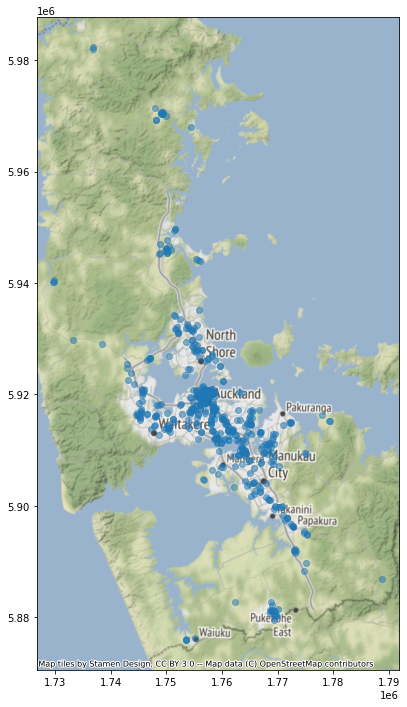

In [587]:
ax = parcels_sample[parcels_sample.LINZmatch_AUP_name.str.contains('Business')].sample(500).plot(alpha=0.5)
ctx.add_basemap(ax, crs=2193)

##### c. **Hdist_rural** Minimum Haversine distance to nearest Rural Zone,   plus
##### c. i. **Hdist_rural_name** Name of rural zone identified 
##### c. ii. **Hdist_rural_code** Numeric code of rural zone identified  
I've included all of these as rural:  
['Rural - Mixed Rural Zone',  
'Rural - Rural Coastal Zone',  
'Rural - Countryside Living Zone',  
'Rural - Rural Production Zone',  
'Rural - Rural Conservation Zone',  
'Rural - Waitakere Ranges Zone',  
'Rural - Waitakere Foothills Zone']    

In [372]:
rural_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('rural - ', na=False)]['ZONE'].unique()

In [436]:
# check that each rural zone code matches with a unique rural zone name 
assert all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in rural_codes])
# dictionary mapping code to names
rural_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in rural_codes}

In [386]:
aup_zones[aup_zones.ZONE_resol.isna()]

WORKFLOWJO   last_edi00 CONTOUR   created_da DocumentUR  \
20853          NaN  20161111011    None  20160718211       None   
121765         NaN  20161111010    None  20160718211       None   

                                      GlobalID GROUPZONE  \
20853   {2D83F680-9587-4D57-AF0B-CB7CA27C3D2C}         6   
121765  {FD3E8BB4-1979-42B5-9A77-5D04AE5190AF}         6   

                  GROUPZONE_    ID  NAME  OBJECTID PARCEL_BAS PARCEL_B00  \
20853   Special purpose zone  None  None     20854       None       None   
121765  Special purpose zone  None  None    121766       None       None   

       PRECINCT PRECINCT_r PRECINCTGR PRECINCT00 SCHEDULE  SHAPE_Area  \
20853      None       None       None       None     None   22.286945   
121765     None       None       None       None     None    4.114962   

        SHAPE_Leng STATUS SUBPRECINC SUBPRECI00 SUBTYPE SUBTYPE_re  TYPE  \
20853    72.629617   None       None       None    None       None  None   
121765   86.135341   None       None       None    None       None  None   

       TYPE_resol VALIDATION        VALIDATI00 VERSIONSTA VERSIONS00 ZONE  \
20853        None          3  Valid and Public          4  Operative   58   
121765       None          3  Valid and Public          4  Operative   58   

       ZONE_resol  ZONEHEIGHT  \
20853        None         NaN   
121765       None         NaN   

                                                 geometry  
20853   POLYGON Z ((1767684.860 5903714.023 33.721, 17...  
121765  POLYGON Z ((1767684.083 5903713.690 33.721, 17...

In [385]:
# 2 NAs in ZONE_resol are from a zone 58, which only has observations
aup_zones[aup_zones.ZONE == '58']

WORKFLOWJO   last_edi00 CONTOUR   created_da DocumentUR  \
20853          NaN  20161111011    None  20160718211       None   
121765         NaN  20161111010    None  20160718211       None   

                                      GlobalID GROUPZONE  \
20853   {2D83F680-9587-4D57-AF0B-CB7CA27C3D2C}         6   
121765  {FD3E8BB4-1979-42B5-9A77-5D04AE5190AF}         6   

                  GROUPZONE_    ID  NAME  OBJECTID PARCEL_BAS PARCEL_B00  \
20853   Special purpose zone  None  None     20854       None       None   
121765  Special purpose zone  None  None    121766       None       None   

       PRECINCT PRECINCT_r PRECINCTGR PRECINCT00 SCHEDULE  SHAPE_Area  \
20853      None       None       None       None     None   22.286945   
121765     None       None       None       None     None    4.114962   

        SHAPE_Leng STATUS SUBPRECINC SUBPRECI00 SUBTYPE SUBTYPE_re  TYPE  \
20853    72.629617   None       None       None    None       None  None   
121765   86.135341   None       None       None    None       None  None   

       TYPE_resol VALIDATION        VALIDATI00 VERSIONSTA VERSIONS00 ZONE  \
20853        None          3  Valid and Public          4  Operative   58   
121765       None          3  Valid and Public          4  Operative   58   

       ZONE_resol  ZONEHEIGHT  \
20853        None         NaN   
121765       None         NaN   

                                                 geometry  
20853   POLYGON Z ((1767684.860 5903714.023 33.721, 17...  
121765  POLYGON Z ((1767684.083 5903713.690 33.721, 17...

In [394]:
rural = aup_zones[aup_zones.ZONE.isin(rural_codes)]

In [579]:
%%time
# method 1, slightly slower: dissolve by zone
rural_by_zone = rural.dissolve(by='ZONE').reset_index(drop=False)
distances = []
codes = []
for index, row in tqdm(parcels_sample.iterrows(), total=len(parcels_sample)):
    distance_candidates = []
    code_candidates = []
    for index, rural_row in rural_by_zone.iterrows():
        distance_candidates.append(row.geometry.distance(rural_row.geometry))
        code_candidates.append(rural_row.ZONE)
    distances.append(distance_candidates)
    codes.append(code_candidates)
    
# all distances (to any zone)
distances = np.array(distances)
codes = np.array(codes)
# indices of minimum distances
min_idx = np.argmin(distances, axis=-1)

  0%|          | 0/9980 [00:00<?, ?it/s]

CPU times: user 1min 2s, sys: 363 ms, total: 1min 3s
Wall time: 1min 2s


In [602]:
%%time
# method 2, slightly faster: dissolve all after subsetting gpd dfs
rural_by_zone_dict = {code: rural[rural.ZONE == code].dissolve() for code in rural_codes}

distances = []
codes = []
for index, row in tqdm(parcels_sample.iterrows(), total=len(parcels_sample)):
    distance_candidates = []
    code_candidates = []
    for code, rural_gdf in rural_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(rural_gdf.geometry[0]))
        code_candidates.append(rural_gdf.ZONE[0])
    distances.append(distance_candidates)
    codes.append(code_candidates)

# all distances (to any zone)
distances = np.array(distances)
codes = np.array(codes)
# indices of minimum distances
min_idx = np.argmin(distances, axis=-1)

  0%|          | 0/9980 [00:00<?, ?it/s]

CPU times: user 56.2 s, sys: 289 ms, total: 56.5 s
Wall time: 56.2 s


In [605]:
parcels_sample['Hdist_rural'] = distances[(np.arange(len(distances)), min_idx)]
parcels_sample['Hdist_rural_code'] = codes[(np.arange(len(distances)), min_idx)]
parcels_sample['Hdist_rural_name'] = parcels_sample.apply(lambda x: rural_code2name[x.Hdist_rural_code], axis=1)

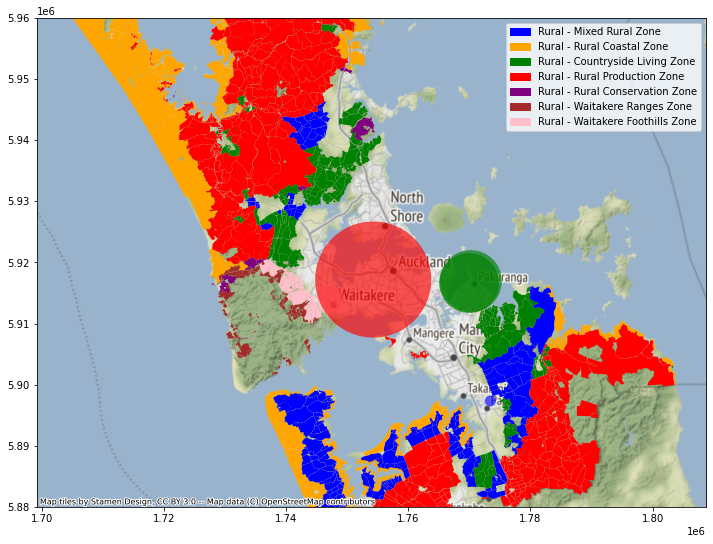

In [682]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan')
name2colour = {name: colour for name, colour in zip(rural_code2name.values(), colours)}

column = 'Hdist_rural'
subsample = parcels_sample[parcels_sample[column] > 0].sample(5)
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']
subsample = subsample[~subsample.is_empty]
# ax = rural.plot(column='ZONE_resol', legend=True)
# subsample.plot(column='Hdist_rural_name', alpha=0.4, ax=ax)
ax = rural.plot(color=[name2colour[z] for z in rural.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_rural_name], alpha=0.65, ax=ax)
plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

ctx.add_basemap(ax=ax, crs=2193)

In [613]:
import matplotlib
matplotlib.colors

<module 'matplotlib.colors' from '/data/miniconda3/envs/house-upzone/lib/python3.8/site-packages/matplotlib/colors.py'>

##### d. **Hdist_bus** Minimum Haversine distance to nearest Business Zone
##### d. i. **Hdist_bus_name**
##### d. ii. **Hdist_bus_code**

In [631]:
business_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('business - ', na=False)]['ZONE'].unique()

In [632]:
# check that each business zone code matches with a unique business zone name 
assert all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in business_codes])
# dictionary mapping code to names
business_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in business_codes}
business_code2name

{'44': 'Business - Neighbourhood Centre Zone',
 '12': 'Business - Mixed Use Zone',
 '17': 'Business - Light Industry Zone',
 '5': 'Business - Heavy Industry Zone',
 '49': 'Business - General Business Zone',
 '1': 'Business - Business Park Zone',
 '22': 'Business - Town Centre Zone',
 '10': 'Business - Metropolitan Centre Zone',
 '7': 'Business - Local Centre Zone',
 '35': 'Business - City Centre Zone'}

In [633]:
business = aup_zones[aup_zones.ZONE.isin(business_codes)]

In [579]:
%%time
# method 1, slightly slower: dissolve by zone
business_by_zone = business.dissolve(by='ZONE').reset_index(drop=False)
distances = []
codes = []
for index, row in tqdm(parcels_sample.iterrows(), total=len(parcels_sample)):
    distance_candidates = []
    code_candidates = []
    for index, business_row in business_by_zone.iterrows():
        distance_candidates.append(row.geometry.distance(business_row.geometry))
        code_candidates.append(business_row.ZONE)
    distances.append(distance_candidates)
    codes.append(code_candidates)
    
# all distances (to any zone)
distances = np.array(distances)
codes = np.array(codes)
# indices of minimum distances
min_idx = np.argmin(distances, axis=-1)

  0%|          | 0/9980 [00:00<?, ?it/s]

CPU times: user 1min 2s, sys: 363 ms, total: 1min 3s
Wall time: 1min 2s


In [634]:
%%time
# method 2, slightly faster: dissolve all after subsetting gpd dfs
business_by_zone_dict = {code: business[business.ZONE == code].dissolve() for code in business_codes}

distances = []
codes = []
for index, row in tqdm(parcels_sample.iterrows(), total=len(parcels_sample)):
    distance_candidates = []
    code_candidates = []
    for code, business_gdf in business_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(business_gdf.geometry[0]))
        code_candidates.append(business_gdf.ZONE[0])
    distances.append(distance_candidates)
    codes.append(code_candidates)

# all distances (to any zone)
distances = np.array(distances)
codes = np.array(codes)
# indices of minimum distances
min_idx = np.argmin(distances, axis=-1)

  0%|          | 0/9980 [00:00<?, ?it/s]

CPU times: user 44.9 s, sys: 230 ms, total: 45.1 s
Wall time: 44.8 s


In [636]:
parcels_sample['Hdist_bus'] = distances[(np.arange(len(distances)), min_idx)]
parcels_sample['Hdist_bus_code'] = codes[(np.arange(len(distances)), min_idx)]
parcels_sample['Hdist_bus_name'] = parcels_sample.apply(lambda x: business_code2name[x.Hdist_bus_code], axis=1)

/data/miniconda3/envs/house-upzone/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


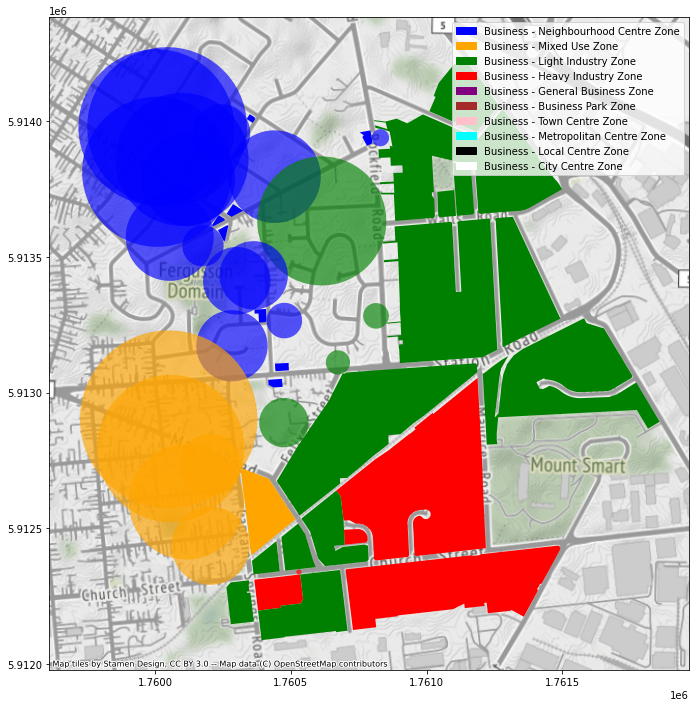

In [677]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan', 'black', 'white')
name2colour = {name: colour for name, colour in zip(business_code2name.values(), colours)}

# hard to see, subset to smaller area
bounds = {'x1': 1.76e6, 'x2': 1.7613e6, 'y1': 5.9123e6, 'y2': 5.914e6}

column = 'Hdist_bus'
subsample = parcels_sample.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']

subsample = subsample[~subsample.is_empty]

business_plot = business.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
ax = business_plot.plot(color=[name2colour[z] for z in business_plot.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_bus_name], alpha=0.65, ax=ax)
# plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

ctx.add_basemap(ax=ax, crs=2193)

##### e. **Hdist_resid** Minimum Haversine distance to nearest Residential Zone,
##### e. i. **Hdist_resid_name**
##### e. ii. **Hdist_resid_code**

In [688]:
resid_codes = aup_zones[aup_zones.ZONE_resol.str.lower().str.contains('resid', na=False)]['ZONE'].unique()

In [689]:
resid_codes

array(['60', '23', '18', '8', '19', '20'], dtype=object)

In [690]:
# check that each resid zone code matches with a unique resid zone name 
assert all([len(aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()) == 1 for code in resid_codes])
# dictionary mapping code to names
resid_code2name = {code: aup_zones[aup_zones.ZONE == code].ZONE_resol.unique()[0] for code in resid_codes}
resid_code2name

{'60': 'Residential - Mixed Housing Urban Zone',
 '23': 'Residential - Large Lot Zone',
 '18': 'Residential - Mixed Housing Suburban Zone',
 '8': 'Residential - Terrace Housing and Apartment Building Zone',
 '19': 'Residential - Single House Zone',
 '20': 'Residential - Rural and Coastal Settlement Zone'}

In [691]:
resid = aup_zones[aup_zones.ZONE.isin(resid_codes)]

In [579]:
%%time
# method 1, slightly slower: dissolve by zone
resid_by_zone = resid.dissolve(by='ZONE').reset_index(drop=False)
distances = []
codes = []
for index, row in tqdm(parcels_sample.iterrows(), total=len(parcels_sample)):
    distance_candidates = []
    code_candidates = []
    for index, resid_row in resid_by_zone.iterrows():
        distance_candidates.append(row.geometry.distance(resid_row.geometry))
        code_candidates.append(resid_row.ZONE)
    distances.append(distance_candidates)
    codes.append(code_candidates)
    
# all distances (to any zone)
distances = np.array(distances)
codes = np.array(codes)
# indices of minimum distances
min_idx = np.argmin(distances, axis=-1)

  0%|          | 0/9980 [00:00<?, ?it/s]

CPU times: user 1min 2s, sys: 363 ms, total: 1min 3s
Wall time: 1min 2s


In [692]:
%%time
# method 2, slightly faster: dissolve all after subsetting gpd dfs
resid_by_zone_dict = {code: resid[resid.ZONE == code].dissolve() for code in resid_codes}

distances = []
codes = []
for index, row in tqdm(parcels_sample.iterrows(), total=len(parcels_sample)):
    distance_candidates = []
    code_candidates = []
    for code, resid_gdf in resid_by_zone_dict.items():
        distance_candidates.append(row.geometry.distance(resid_gdf.geometry[0]))
        code_candidates.append(resid_gdf.ZONE[0])
    distances.append(distance_candidates)
    codes.append(code_candidates)

# all distances (to any zone)
distances = np.array(distances)
codes = np.array(codes)
# indices of minimum distances
min_idx = np.argmin(distances, axis=-1)

  0%|          | 0/9980 [00:00<?, ?it/s]

CPU times: user 2min 9s, sys: 509 ms, total: 2min 9s
Wall time: 2min 8s


In [693]:
parcels_sample['Hdist_resid'] = distances[(np.arange(len(distances)), min_idx)]
parcels_sample['Hdist_resid_code'] = codes[(np.arange(len(distances)), min_idx)]
parcels_sample['Hdist_resid_name'] = parcels_sample.apply(lambda x: resid_code2name[x.Hdist_resid_code], axis=1)

/data/miniconda3/envs/house-upzone/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


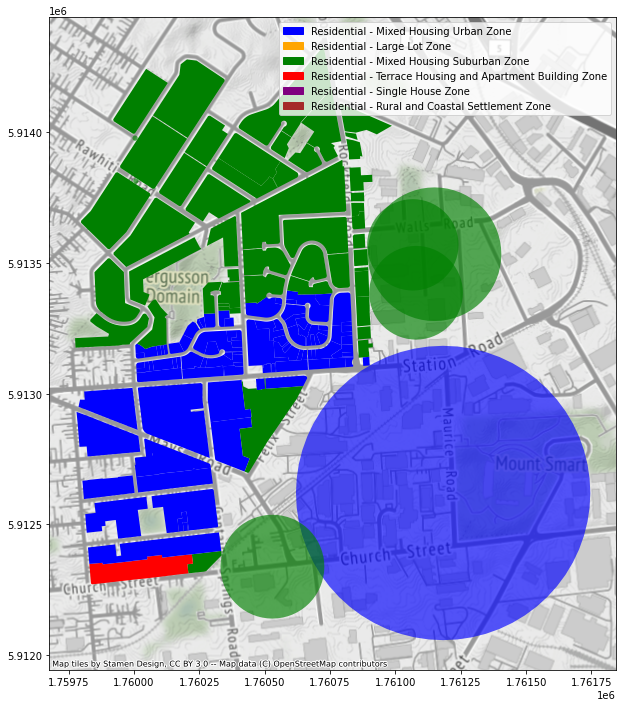

In [694]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

colours = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'cyan', 'black', 'white')
name2colour = {name: colour for name, colour in zip(resid_code2name.values(), colours)}

# hard to see, subset to smaller area
bounds = {'x1': 1.76e6, 'x2': 1.7613e6, 'y1': 5.9123e6, 'y2': 5.914e6}

column = 'Hdist_resid'
subsample = parcels_sample.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']

subsample = subsample[~subsample.is_empty]

resid_plot = resid.cx[bounds['x1']:bounds['x2'], bounds['y1']:bounds['y2']]
ax = resid_plot.plot(color=[name2colour[z] for z in resid_plot.ZONE_resol])
subsample.plot(color=[name2colour[z] for z in subsample.Hdist_resid_name], alpha=0.65, ax=ax)
# plt.ylim((5.88e6, 5.96e6))

# add legend
legend_patches = [mpatches.Patch(color=col, label=name) for name, col in name2colour.items()]
plt.legend(handles=legend_patches)

ctx.add_basemap(ax=ax, crs=2193)

##### f. **Hdist_SH** Minimum Haversine distance to Residential - Single House Zone 
##### g. **Hdist_MHS** Minimum Haversine distance to Residential - Mixed Housing Suburban Zone
##### h. **Hdist_MHU** Minimum Haversine distance to Residential - Mixed Housing Urban Zone  
##### i. **Zone Hdist_THA** Minimum Haversine distance to Residential - Terrace Housing and Apartments
Note: this is the real name for i: 'Residential - Terrace Housing and Apartment Building Zone'

In [707]:
%%time
postfix2name = {
            'SH': 'Residential - Single House Zone',
            'MHS': 'Residential - Mixed Housing Suburban Zone',
            'MHU': 'Residential - Mixed Housing Urban Zone',
            'THA': 'Residential - Terrace Housing and Apartment Building Zone'
               }
for postfix, zone in tqdm(postfix2name.items()):
    resid_gdf = resid[resid.ZONE_resol == zone].dissolve()
    parcels_sample[f'Hdist_{postfix}'] = parcels_sample.apply(lambda x: x.geometry.distance(resid_gdf.geometry[0]), axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 1min 42s, sys: 78.1 ms, total: 1min 42s
Wall time: 1min 42s


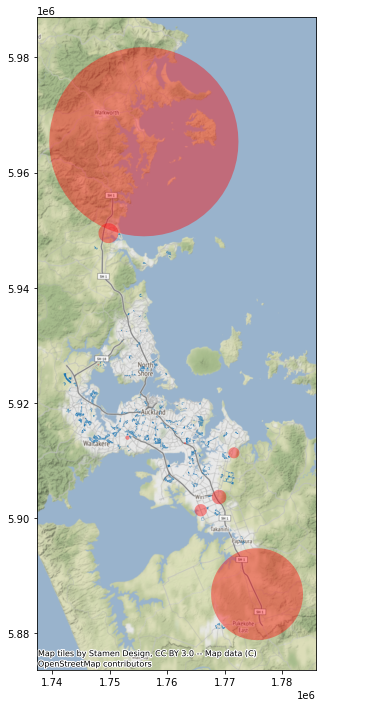

In [710]:
postfix = 'THA'
column = f'Hdist_{postfix}'
subsample = parcels_sample.sample(10)
subsample['buffer'] = subsample.apply(lambda x: x.geometry.buffer(x[column]), axis=1)
subsample['geometry'] = subsample['buffer']
ax = subsample.plot(color='red', alpha=0.4)
resid[resid.ZONE_resol == postfix2name[postfix]].plot(ax=ax)
ctx.add_basemap(ax, crs=2193)

## 3. Local Area (LA) Information (information on the LA that the consent is located in): 

##### a. Name (just the string is fine; I did not generate numeric codes for the local areas generated) **Local_Area_name**

In [713]:
LA = gpd.read_file('input/Modified_Community_Boards_SHP.zip').to_crs(2193)
LA.sample(3)

OBJECTID              Local_Area  \
8       10.0          Hibiscus Coast   
17      21.0              Papatoetoe   
2       25.0  Rodney-Kumeu-Riverhead   

                                             geometry  
8   MULTIPOLYGON (((1752023.352 5954803.281, 17520...  
17  POLYGON ((1765105.421 5908611.893, 1765113.661...  
2   POLYGON ((1742532.808 5931237.574, 1742490.377...

In [718]:
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample = gpd.sjoin(parcels_sample, LA[['Local_Area', 'geometry']]).drop(columns=['index_right'])
parcels_sample = parcels_sample.rename(columns={'Local_Area': 'Local_Area_name'})

## 4. 2018 Statistical Area 2 Information (information on the 2018SA2 that the consent is located in)

##### a. Name (string) **SA22018_name**
##### b. Numeric code **SA22018_code**

In [11]:
sa2 = gpd.read_file('NZ-SA/statistical-area-2-2020-generalised.gdb').to_crs(2193)
sa2.sample(3)

In [82]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample = gpd.sjoin(parcels_sample, sa2[['SA22020_V1_00_NAME', 'SA22020_V1_00', 'geometry']]).drop(columns=['index_right'])
parcels_sample = parcels_sample.rename(columns={'SA22020_V1_00_NAME': 'SA22018_name', 'SA22020_V1_00': 'SA22018_code'})

CPU times: user 8.29 s, sys: 3.88 ms, total: 8.29 s
Wall time: 8.29 s


## 5. Area Unit Information (information on the 2013AU  that the consent is located in):

##### a. Name (string) **AU2013_name**
##### b. Numeric code **AU2013_code**

In [101]:
au2013 = gpd.read_file('input/area-unit-2013.gdb.zip').to_crs(2193)
au2013.sample(3)

AU2013_V1_00                  AU2013_V1_00_NAME  AREA_SQ_KM  \
1481       573903                     Newlands North    0.804087   
958        525202                     Kawakawa-Orere  105.216001   
608        597102  Inland Water-Lake Ellesmere South   63.304671   

      LAND_AREA_SQ_KM  Shape_Length  \
1481         0.804087   5958.640337   
958        105.216001  57437.556145   
608          0.000000  75233.330853   

                                               geometry  
1481  MULTIPOLYGON (((174.82896 -41.21949, 174.83011...  
958   MULTIPOLYGON (((175.14259 -36.93214, 175.14265...  
608   MULTIPOLYGON (((172.57398 -43.76779, 172.57401...

In [103]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample = gpd.sjoin(parcels_sample, au2013[['AU2013_V1_00_NAME', 'AU2013_V1_00', 'geometry']]).drop(columns=['index_right'])
parcels_sample = parcels_sample.rename(columns={'AU2013_V1_00_NAME': 'AU2013_name', 'AU2013_V1_00': 'AU2013_code'})

CPU times: user 6.96 s, sys: 0 ns, total: 6.96 s
Wall time: 6.96 s


## 6. 2018 Meshblock Information (information on the 2018MB  that the consent is located in):

##### a. Code **MB2018_code**

In [100]:
mb2018 = gpd.read_file('input/meshblock-2018-clipped-generalised.gdb.zip').to_crs(4326)
mb2018.sample(3)

MB2018_V1_00 LANDWATER LANDWATER_NAME  LAND_AREA_SQ_KM  AREA_SQ_KM  \
52865      4011926        12       Mainland         0.173710    0.173710   
23832      1429800        12       Mainland         0.021918    0.021918   
15554      0759520        12       Mainland         0.020695    0.020695   

       SHAPE_Length                                           geometry  
52865   2129.422679  MULTIPOLYGON (((174.91945 -36.94519, 174.92053...  
23832    731.394363  MULTIPOLYGON (((176.91682 -39.49291, 176.91702...  
15554    928.355735  MULTIPOLYGON (((174.91840 -37.01411, 174.91871...

In [97]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid']
parcels_sample = gpd.sjoin(parcels_sample, mb2018[['MB2018_V1_00', 'geometry']]).drop(columns=['index_right'])
parcels_sample = parcels_sample.rename(columns={'MB2018_V1_00': 'MB2018_code'})

CPU times: user 11.3 s, sys: 8.2 ms, total: 11.3 s
Wall time: 11.3 s


## 7. 2013 Meshblock Information (information on the 2013MB  that the consent is located in):

##### a. Code **MB2013_code**

In [84]:
mb2013 = gpd.read_file('input/meshblock-2013.gdb.zip').to_crs(4326)
mb2013.sample(3)

In [87]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample = gpd.sjoin(parcels_sample, mb2013[['MeshblockNumber', 'geometry']]).drop(columns=['index_right'])
parcels_sample = parcels_sample.rename(columns={'MeshblockNumber': 'MB2013_code'})

CPU times: user 11.4 s, sys: 7.05 ms, total: 11.4 s
Wall time: 11.4 s


## 8. Additional distance information from consent location  
For these distance calculations, use EPSG 2193 (less distortion).

In [116]:
parcels_sample['geometry'] = parcels_sample['geometry_centroid']
parcels_sample = parcels_sample.to_crs(2193)
parcels_sample.sample(3)

id       appellation      affected_surveys     parcel_intent  \
102782  4896031    Lot 1 DP 61837              DP 61837              DCDB   
119786  4931702   Lot 4 DP 166054             DP 166054              DCDB   
362342  7415715  Lot 23 DP 455616  DP 455616, DP 462513  Fee Simple Title   

       topology_type statutory_actions   land_district     titles  \
102782       Primary              None  North Auckland  NA17C/935   
119786       Primary              None  North Auckland  NA100D/34   
362342       Primary              None  North Auckland     586776   

        survey_area  calc_area                         geometry  \
102782        685.0      685.0  POINT (1773608.374 5914596.096)   
119786      52130.0    50575.0  POINT (1783027.533 5889659.615)   
362342        103.0      103.0  POINT (1763989.858 5916157.717)   

                  geometry_centroid  \
102782  POINT (174.94849 -36.89867)   
119786  POINT (175.06020 -37.12153)   
362342  POINT (174.84025 -36.88632)   

                                         geometry_polygon      SA22018_name  \
102782  MULTIPOLYGON (((174.94827 -36.89874, 174.94841...        Cockle Bay   
119786  MULTIPOLYGON (((175.06295 -37.12105, 175.06293...           Ararimu   
362342  MULTIPOLYGON (((174.84016 -36.88629, 174.84020...  Stonefields West   

       SA22018_code MB2013_code MB2018_code  AU2013_name AU2013_code  
102782       153400     0655102     0655102   Cockle Bay      521502  
119786       166400     0815302     0815302        Hunua      521132  
362342       144900     0465305     4000293  Stonefields      517202

#### a. Minimum Haversine distance to coastline **Hdist_coast**  
There are a few different datasets that could be used for this:  
    - NZ Coastlines (Topo 1:50k) https://data.linz.govt.nz/layer/50258-nz-coastlines-topo-150k/
    - NZ Coastline - mean high water https://data.linz.govt.nz/layer/105085-nz-coastline-mean-high-water/
    - NZ Coastlines and Islands Polygons (Topo 1:50k) https://data.linz.govt.nz/layer/51153-nz-coastlines-and-islands-polygons-topo-150k/  

The first doesn't have islands (e.g. Waiheke).  
The second is probably most appropriate.

In [ ]:
%%time
bounds2193 = {'x1': 1.5e6, 'x2':2e6, 'y1':5.8e6, 'y2':6.1e6}
coastline = gpd.read_file('input/lds-nz-coastline-mean-high-water-FGDB.zip!nz-coastline-mean-high-water.gdb').to_crs(2193)
coastline = coastline.cx[bounds2193['x1']:bounds2193['x2'], bounds2193['y1']:bounds2193['y2']]
coastline_dissolved = coastline.dissolve()

In [169]:
%%time
parcels_sample['Hdist_coast'] = parcels_sample.apply(lambda x: x.geometry.distance(coastline_dissolved.geometry[0]), axis=1)

CPU times: user 14.3 s, sys: 0 ns, total: 14.3 s
Wall time: 14.3 s


<AxesSubplot:>

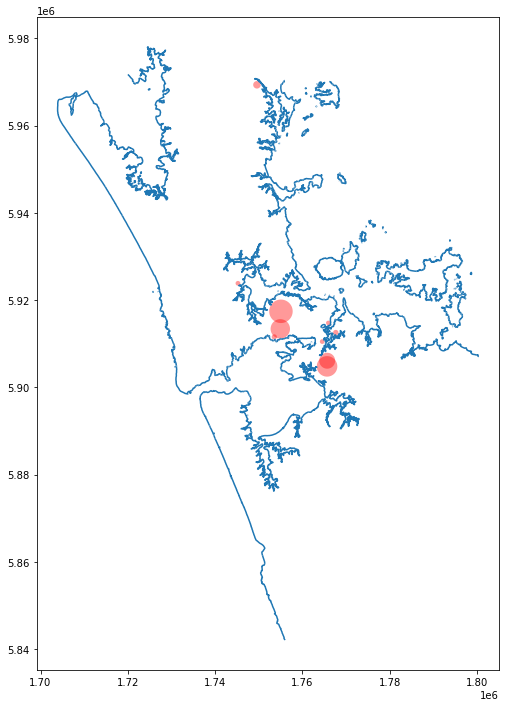

In [198]:
# if distance work, then red circles should extend to the nearest coastline, and no further
subsample = parcels_sample.sample(10)
subsample['coast_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_coast), axis=1)
subsample['geometry'] = subsample['coast_buffer']
ax = subsample.plot(color='red', alpha=0.4)
coastline.cx[1.7e6:1.8e6, 5.85e6:5.97e6].plot(ax=ax)

##### b. Minimum Haversinedistance to Open Space(set of AUP Zones) **Hdist_open**

##### c. Minimum Haversine distance to motorway **Hdist_motorway**
##### d. Minimum Haversine distance to main arterial road **Hdist_main_road**

In [238]:
roads = gpd.read_file('input/lds-nz-road-centrelines-topo-150k-FGDB.zip!nz-road-centrelines-topo-150k.gdb').to_crs(2193)
roads = roads.cx[bounds2193['x1']:bounds2193['x2'], bounds2193['y1']:bounds2193['y2']]
highways = roads[~roads.hway_num.isna()]
highways_dissolved = highways.dissolve()

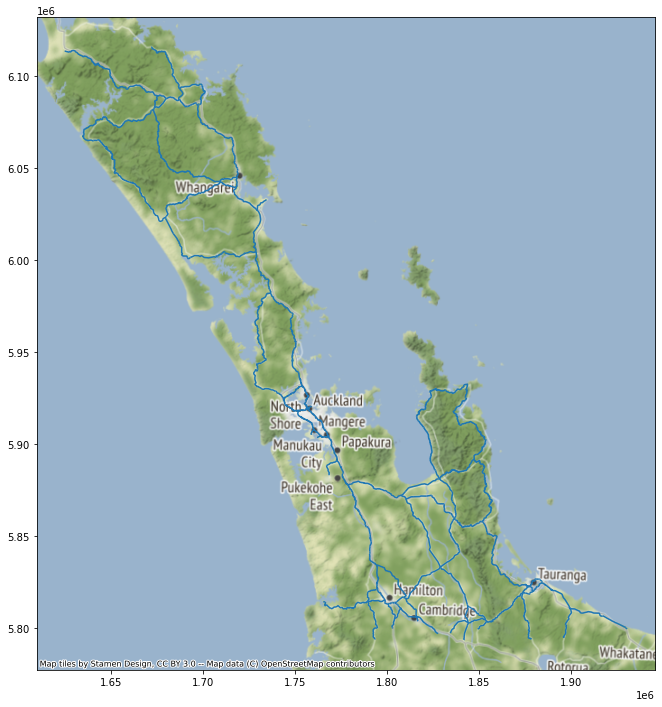

In [236]:
ax = highways.plot()
ctx.add_basemap(ax, crs=2193)

In [240]:
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample['Hdist_motorway'] = parcels_sample.apply(lambda x: x.geometry.distance(highways_dissolved.geometry[0]), axis=1)

<AxesSubplot:>

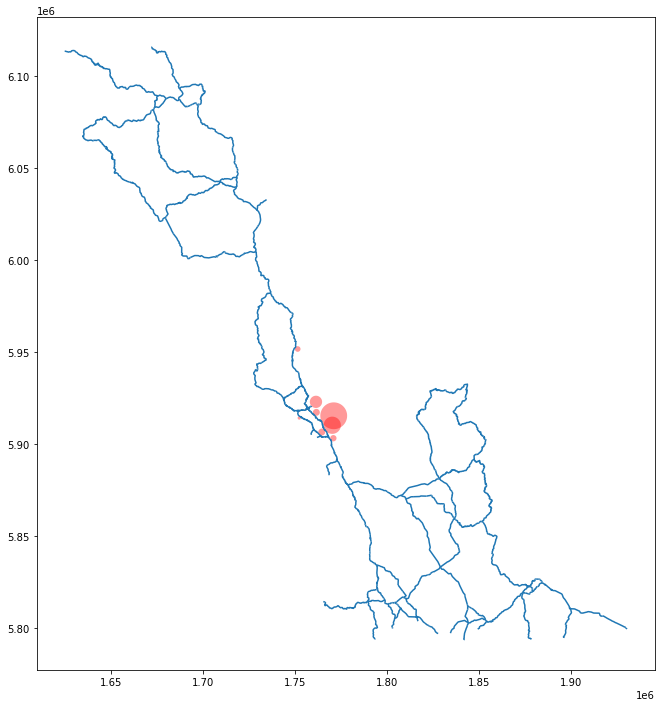

In [241]:
# if distance work, then red circles should extend to the nearest coastline, and no further
subsample = parcels_sample.sample(10)
subsample['highway_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_motorway), axis=1)
subsample['geometry'] = subsample['highway_buffer']
ax = subsample.plot(color='red', alpha=0.4)
highways.plot(ax=ax)

##### e. Minimum Haversine distance to rail line **Hdist_rail**

In [244]:
railroads = gpd.read_file('input/lds-nz-railway-centrelines-topo-150k-SHP.zip').to_crs(2193)
railroads = railroads.cx[bounds2193['x1']:bounds2193['x2'], bounds2193['y1']:bounds2193['y2']]
railroads_dissolved = railroads.dissolve()

In [248]:
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample['Hdist_rail'] = parcels_sample.apply(lambda x: x.geometry.distance(railroads_dissolved.geometry[0]), axis=1)

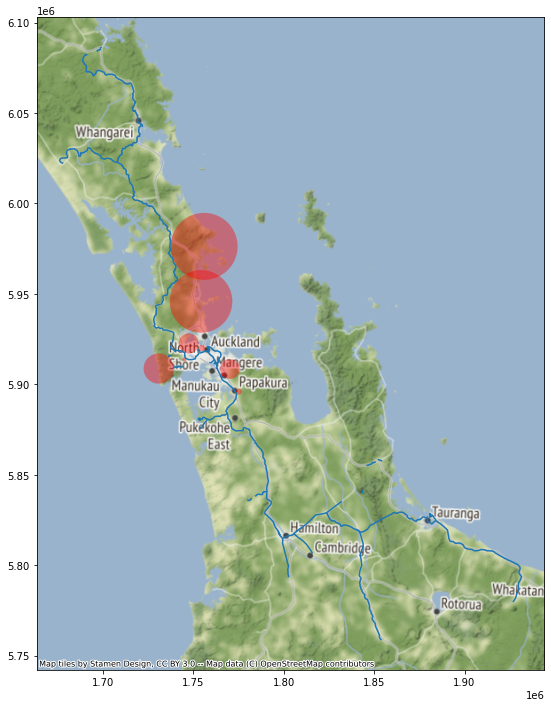

In [249]:
# if distance work, then red circles should extend to the nearest coastline, and no further
subsample = parcels_sample.sample(10)
subsample['rail_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_rail), axis=1)
subsample['geometry'] = subsample['rail_buffer']
ax = subsample.plot(color='red', alpha=0.4)
railroads_dissolved.plot(ax=ax)
ctx.add_basemap(ax, crs=2193)

##### f. Haversine distance to downtown (use Skytower coordinates) **Hdist_skytower**

In [211]:
skytower = [-36.84838748948485, 174.7621736911587]
skytower = gpd.points_from_xy(x=[skytower[1]], y=[skytower[0]])
skytower = gpd.GeoDataFrame([{"name": "Skytower", "value": 1}], geometry=skytower, crs="EPSG:4326").to_crs(epsg=2193)

In [216]:
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample['Hdist_skytower'] = parcels_sample.apply(lambda x: x.geometry.distance(skytower.geometry[0]), axis=1)

<AxesSubplot:>

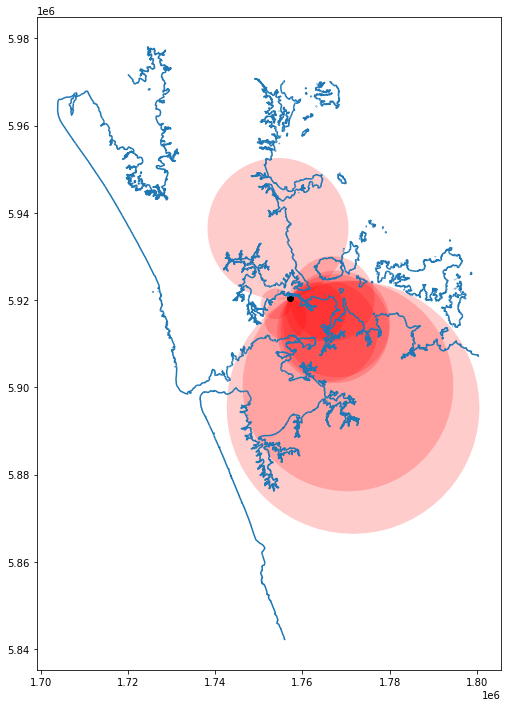

In [255]:
# if distance works, then red circles should extend to the nearest sky tower, and no further
subsample = parcels_sample.sample(10)
subsample['skytower_buffer'] = subsample.apply(lambda x: x.geometry.buffer(x.Hdist_skytower), axis=1)
subsample['geometry'] = subsample['skytower_buffer']
ax = subsample.plot(color='red', alpha=0.2)
skytower.plot(ax=ax, color='black')
coastline.cx[1.7e6:1.8e6, 5.85e6:5.97e6].plot(ax=ax)

## 9. Special Housing Area (SpHAs)
Indicator (1 or 0) for consent located in SpHAs **SpHA_indicator**  
Note: here I've used centroids. Maybe should use parcel polygons instead.

In [268]:
spha = gpd.read_file('input/AC_Special_Housing_Area.zip').to_crs(2193)
spha_dissolved = spha.dissolve()
assert(len(spha_dissolved) == 1)

In [275]:
%%time
parcels_sample['geometry'] = parcels_sample['geometry_centroid_2193']
parcels_sample['SpHA_indicator'] = parcels_sample.apply(lambda x: spha_dissolved.geometry.contains(x.geometry), axis=1)

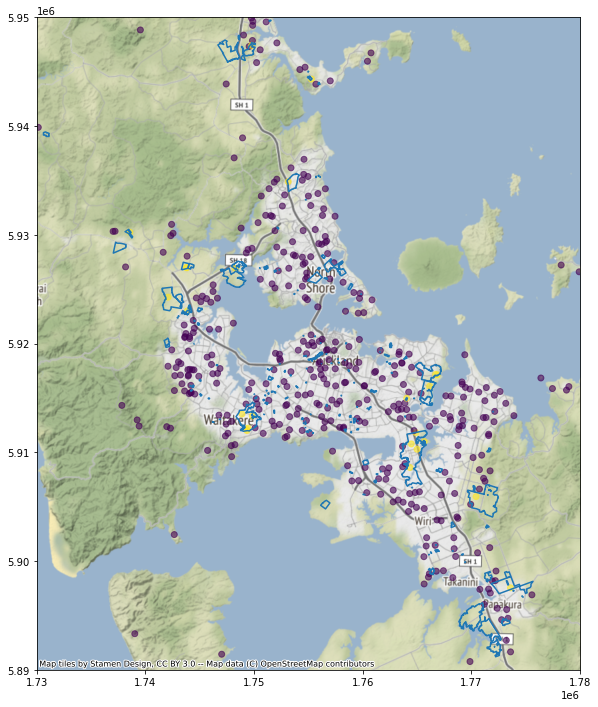

In [296]:
# if distance works, then red circles should extend to the nearest sky tower, and no further
subsample = parcels_sample.sample(500)
ax=subsample.plot(column='SpHA_indicator', alpha=0.6)
plt.ylim((5.89e6, 5.95e6))
plt.xlim((1.73e6, 1.78e6))
spha_dissolved.boundary.plot(ax=ax)
ctx.add_basemap(ax, crs=spha_dissolved.crs)

## 10. Ranged Address Indicator

## 11. Matching Type Indicators
##### a. LINZ_MATCH_CODE
##### b. LINZ_2ND_MATCH_CODE